<a href="https://colab.research.google.com/github/beckslopez/Music-Generation-and-Classification-Using-NNs/blob/main/Music_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import requests

# fname = "music.zip"
# url = "https://osf.io/drjhb/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)

In [ ]:

# with ZipFile(fname, 'r') as zipObj:
#   # Extract all the contents of zip file in different directory
#   zipObj.extractall()

## Train a simple CNN 

In [ ]:
# Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  train_loss=torch.stack(train_loss).detach().to('cpu').numpy()
  # train_acc=torch.stack(train_acc).detach().to('cpu').numpy()
  # validation_loss=torch.stack(validation_loss).detach().to('cpu').numpy()
  # validation_acc=torch.stack(validation_acc).detach().to('cpu').numpy()
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [ ]:
device = set_device()

GPU is enabled in this notebook.


In [ ]:
# Create folder with training, testing and validation data.

spectrograms_dir = 'drive/My Drive/Colab Notebooks/563_FinalProject/Images/'
folder_names = ['/content/drive/MyDrive/Colab Notebooks/563_FinalProject/Train/', 
                '/content/drive/MyDrive/Colab Notebooks/563_FinalProject/Test/', 
                '/content/drive/MyDrive/Colab Notebooks/563_FinalProject/Val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
genres = genres[:-1]
print(genres)

for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:20]
  #val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))
  

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  # for f in val_files:
  #   shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))


['blues', 'rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical']


In [ ]:
# Data loading.
btch_sz=25
train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=btch_sz, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=btch_sz, shuffle=True, num_workers=0)

print(val_dir)
val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=btch_sz, shuffle=True, num_workers=0)

/content/drive/MyDrive/Colab Notebooks/563_FinalProject/Val/


In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=1280, out_features=10)
    # self.fc1 = nn.Linear(in_features=9856, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    # x = self.batchnorm1(x)
    # x = self.dropout(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    # x = self.batchnorm2(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    # x = self.batchnorm3(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    # x = self.batchnorm4(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    # x = self.batchnorm5(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    # x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, test_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        predicted_indx= predicted.detach().to('cpu').numpy()

        # for i in range(1,btch_sz):
        #   p=predicted_indx[i]
        #   plt.imshow(data.detach().cpu().numpy()[i,0,:,:])
        #   plt.show()

        if epoch%1 == 0:
          predicted_list=predicted.detach().to('cpu').numpy()
          val_list=target.detach().to('cpu').numpy()

      validation_loss.append(running_loss/len(test_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc,predicted_list,val_list

In [ ]:
# Run training.
epochs=50
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc,predicted_list,val_list = train(net, device, train_loader, test_loader, epochs)


  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


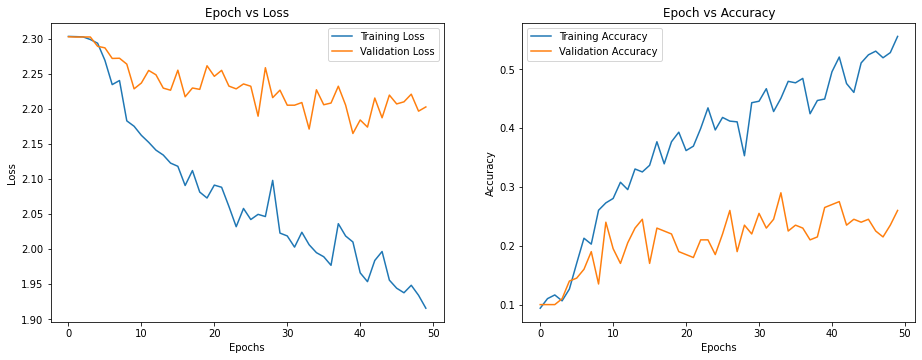

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


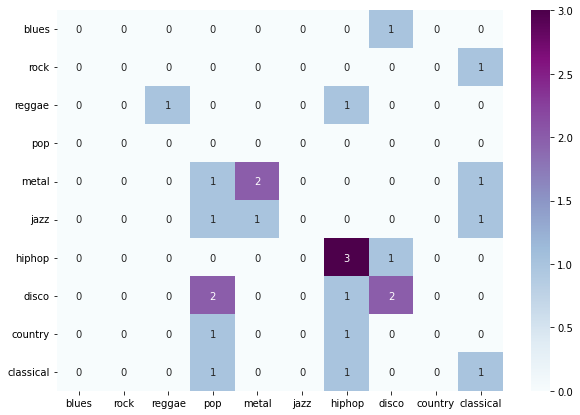

In [ ]:
model=net
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []
with tqdm(range(epochs), unit='epoch') as tepochs:
  tepochs.set_description('Training')
  for epoch in tepochs:
    model.train()
    # keep track of the running loss
    running_loss = 0.
    correct, total = 0, 0


for data, target in val_loader:
# getting the test set
  data, target = data.to(device), target.to(device)
  optimizer.zero_grad()
  output = model(data)
  loss = criterion(output, target)
  tepochs.set_postfix(loss=loss.item())
  running_loss += loss.item()
  # get accuracy
  _, predicted = torch.max(output, 1)
  total += target.size(0)
  correct += (predicted == target).sum().item()

  predicted_indx= predicted.detach().to('cpu').numpy()

  for i in range(1,18):
      p=predicted_indx[i]
      # plt.imshow(data.detach().cpu().numpy()[i,0,:,:])
      # plt.show()
    
  if epoch%50 == 0:
    predicted_list=predicted.detach().to('cpu').numpy()
    val_list=target.detach().to('cpu').numpy()

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(val_list, predicted_list)
df_cm = pd.DataFrame(cm1, index = [i for i in genres],
              columns = [i for i in genres])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="BuPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')
epochs_range = range(500)